# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [44]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy
from sklearn.model_selection import ParameterGrid

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [6]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [7]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for FullyConnectedLayer1_W
Gradient check passed!
Checking gradient for FullyConnectedLayer1_B
Gradient check passed!
Checking gradient for FullyConnectedLayer2_W
Gradient check passed!
Checking gradient for FullyConnectedLayer2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [8]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for FullyConnectedLayer1_W
Gradient check passed!
Checking gradient for FullyConnectedLayer1_B
Gradient check passed!
Checking gradient for FullyConnectedLayer2_W
Gradient check passed!
Checking gradient for FullyConnectedLayer2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [12]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.13333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [21]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.110817, Train accuracy: 0.285556, val accuracy: 0.297000
Loss: 2.118701, Train accuracy: 0.373667, val accuracy: 0.372000
Loss: 1.836729, Train accuracy: 0.448778, val accuracy: 0.448000
Loss: 1.452939, Train accuracy: 0.522222, val accuracy: 0.530000
Loss: 1.510363, Train accuracy: 0.570667, val accuracy: 0.573000
Loss: 1.537270, Train accuracy: 0.609556, val accuracy: 0.596000
Loss: 1.236472, Train accuracy: 0.640556, val accuracy: 0.634000
Loss: 1.388122, Train accuracy: 0.666889, val accuracy: 0.651000
Loss: 1.534981, Train accuracy: 0.672000, val accuracy: 0.668000
Loss: 1.175459, Train accuracy: 0.688667, val accuracy: 0.676000
Loss: 0.994926, Train accuracy: 0.695333, val accuracy: 0.675000
Loss: 0.803819, Train accuracy: 0.707889, val accuracy: 0.689000
Loss: 1.777736, Train accuracy: 0.711556, val accuracy: 0.679000
Loss: 0.654220, Train accuracy: 0.716000, val accuracy: 0.688000
Loss: 1.036180, Train accuracy: 0.734667, val accuracy: 0.711000
Loss: 0.983492, Train acc

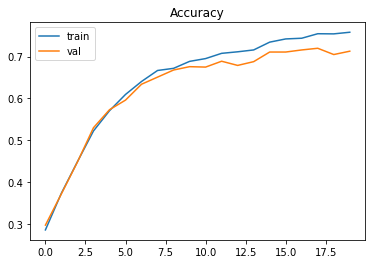

In [26]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.title('Accuracy')
plt.legend()

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [28]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.411403, Train accuracy: 0.286444, val accuracy: 0.296000
Loss: 2.152245, Train accuracy: 0.359444, val accuracy: 0.352000
Loss: 2.274372, Train accuracy: 0.441444, val accuracy: 0.426000
Loss: 2.030443, Train accuracy: 0.500556, val accuracy: 0.478000
Loss: 1.836237, Train accuracy: 0.547333, val accuracy: 0.525000
Loss: 1.600846, Train accuracy: 0.606556, val accuracy: 0.566000
Loss: 1.860395, Train accuracy: 0.629889, val accuracy: 0.592000
Loss: 1.804865, Train accuracy: 0.641778, val accuracy: 0.613000
Loss: 1.359208, Train accuracy: 0.657333, val accuracy: 0.634000
Loss: 1.776783, Train accuracy: 0.667222, val accuracy: 0.644000
Loss: 1.280106, Train accuracy: 0.683778, val accuracy: 0.646000
Loss: 1.289726, Train accuracy: 0.689111, val accuracy: 0.649000
Loss: 0.908078, Train accuracy: 0.695111, val accuracy: 0.658000
Loss: 0.897087, Train accuracy: 0.698000, val accuracy: 0.656000
Loss: 1.083855, Train accuracy: 0.713111, val accuracy: 0.674000
Loss: 1.170385, Train acc

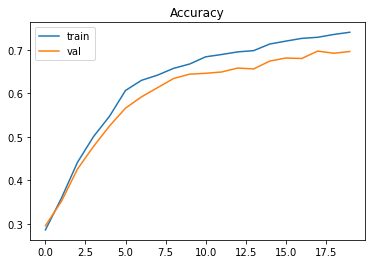

In [33]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.title('Accuracy')
plt.legend()

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [39]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.995)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 1.575811, Train accuracy: 0.558111, val accuracy: 0.552000
Loss: 1.179122, Train accuracy: 0.656111, val accuracy: 0.620000
Loss: 1.161654, Train accuracy: 0.680667, val accuracy: 0.657000
Loss: 1.620276, Train accuracy: 0.709778, val accuracy: 0.674000
Loss: 1.186745, Train accuracy: 0.729556, val accuracy: 0.698000
Loss: 1.378247, Train accuracy: 0.742111, val accuracy: 0.685000
Loss: 0.855872, Train accuracy: 0.748444, val accuracy: 0.700000
Loss: 0.808384, Train accuracy: 0.768333, val accuracy: 0.699000
Loss: 1.038059, Train accuracy: 0.775111, val accuracy: 0.699000
Loss: 1.063320, Train accuracy: 0.792111, val accuracy: 0.705000
Loss: 1.621918, Train accuracy: 0.789444, val accuracy: 0.714000
Loss: 1.282796, Train accuracy: 0.808889, val accuracy: 0.736000
Loss: 1.274567, Train accuracy: 0.800222, val accuracy: 0.723000
Loss: 1.098964, Train accuracy: 0.783333, val accuracy: 0.710000
Loss: 1.599626, Train accuracy: 0.831667, val accuracy: 0.734000
Loss: 0.786941, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [41]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.825113, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 2.202643, Train accuracy: 0.666667, val accuracy: 0.133333
Loss: 1.401730, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 1.383219, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.842613, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.867235, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.727567, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.375536, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.418085, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.420404, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.466187, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.382176, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.306958, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.332971, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.292672, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.374627, Train acc

Loss: 0.212410, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.212231, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.212904, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.211721, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.214998, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.212126, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.212793, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.212926, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.210761, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.209512, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.209808, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.212146, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.209133, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.209911, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.208048, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.212041, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [42]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.285483, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 1.755749, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 1.776655, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.823047, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.564595, Train accuracy: 1.000000, val accuracy: 0.133333
Loss: 0.621806, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.590220, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.752491, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.438313, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.361435, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.419764, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.334053, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.368454, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.272485, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.314906, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.265801, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [56]:
# Let's train the best one-hidden-layer network we can
best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

params_model = ParameterGrid({'hidden_layer_size':[100, 128], 'reg':np.logspace(-5,-1, num=5)})
params_trainer = ParameterGrid({'learning_rate':np.logspace(-5, -1, num=5), 'batch_size':[32, 64, 128], 
                                'learning_rate_decay':[0.9, 0.95, 0.99]})

param_model, param_trainer = {'hidden_layer_size':100, 'reg':1e-5}, {'learning_rate':1e-2, 'batch_size':64, 
                                                                    'learning_rate_decay':0.95}
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, **param_model)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), num_epochs=20, **param_trainer)

loss_history, train_history, val_history = trainer.fit()
best_val_accuracy = val_history[-1]
best_classifier = model
print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 1.692055, Train accuracy: 0.386222, val accuracy: 0.390000
Loss: 1.388352, Train accuracy: 0.563222, val accuracy: 0.560000
Loss: 1.360969, Train accuracy: 0.616333, val accuracy: 0.607000
Loss: 1.294685, Train accuracy: 0.677444, val accuracy: 0.657000
Loss: 1.354936, Train accuracy: 0.704556, val accuracy: 0.678000
Loss: 1.053817, Train accuracy: 0.720000, val accuracy: 0.704000
Loss: 0.978976, Train accuracy: 0.732889, val accuracy: 0.698000
Loss: 1.048241, Train accuracy: 0.748444, val accuracy: 0.726000
Loss: 0.735634, Train accuracy: 0.760333, val accuracy: 0.718000
Loss: 0.945870, Train accuracy: 0.766889, val accuracy: 0.722000
Loss: 1.104724, Train accuracy: 0.771333, val accuracy: 0.735000
Loss: 0.506410, Train accuracy: 0.782667, val accuracy: 0.726000
Loss: 0.462429, Train accuracy: 0.784333, val accuracy: 0.731000
Loss: 0.957111, Train accuracy: 0.788667, val accuracy: 0.730000
Loss: 0.978564, Train accuracy: 0.802444, val accuracy: 0.735000
Loss: 0.387041, Train acc

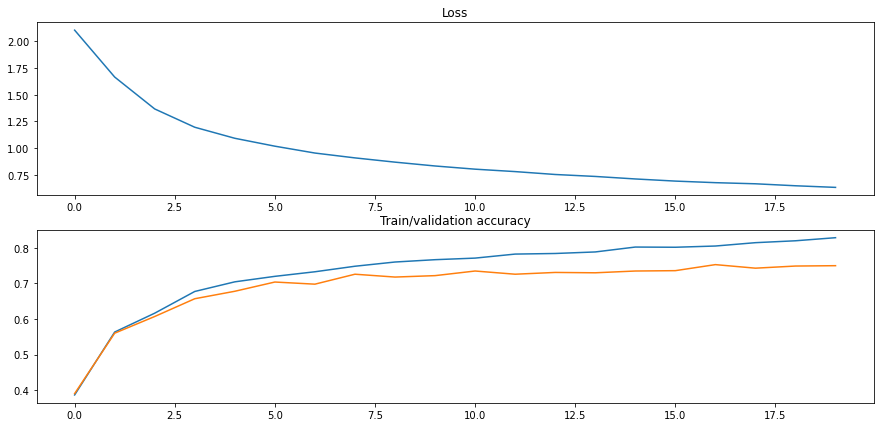

In [57]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [58]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.712000
